In [ ]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba
!pip install wurlitzer
!pip install orca

# git repo setup

In [ ]:
!rm parallelized-PSO-clustering -r
!git clone https://ms03831:hahaha:D1985764@github.com/ms03831/parallelized-PSO-clustering

rm: cannot remove 'parallelized-PSO-clustering': No such file or directory
Cloning into 'parallelized-PSO-clustering'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 114 (delta 55), reused 64 (delta 17), pack-reused 0
Receiving objects: 100% (114/114), 841.36 KiB | 1.03 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [40]:
#%cd parallelized-PSO-clustering/
#%cd Code/kmeans
%cp ../drive/MyDrive/Colab\ Notebooks/kMeansClusteringC* .
%ls .

cp: cannot stat '../drive/MyDrive/Colab Notebooks/kMeansClusteringC*': No such file or directory
kmeans_cpu.py  kmeans_gpu.py  __pycache__/


In [ ]:
!git config --global user.email "ms03831@st.habib.edu.pk"
!git config --global user.name "ms03831"

In [37]:
commitmsg = "kmeans cpu updated"
!git add kmeans_cpu.py
!git commit -m commitmsg
!git push origin main

[main 113d73f] commitmsg
 1 file changed, 13 insertions(+), 7 deletions(-)
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 597 bytes | 597.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/ms03831/parallelized-PSO-clustering
   3569d74..113d73f  main -> main


In [ ]:
commitmsg = "kmeans gpu still not working"
!git add kmeans_gpu.py
!git commit -m commitmsg
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


# Code

4.13880702127276
0.4989945154505495
0.20146694655550154
0.06214068015984936
0.06830019676273832
0.10016508116279518
0.3166366325052011
0.4572593557081449
0.17553089369350125
0.003325515229697015
0.003162565127698152
0.004064424758375113
0.0035884232249442562
0.0035865819389515677
0.003032548442107928
0.004551921000579221
0.005324731736428578
0.004082940472140606
0.0014518558631461558
0.0014571436750737562
0.00044461054104196136
0.00041626273789757635
0.00104786423093413
0.0002572115099317976
0.00023573229776245876
0.0
(5, 2)


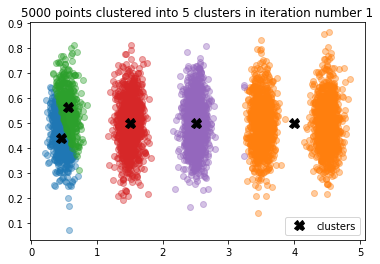

The score of best Kmeans clustering is: 589.3221245437137


In [36]:
import kmeans_cpu
import importlib
importlib.reload(kmeans_cpu)
from kmeans_cpu import runKMeans, initializePoints, clusterQuality
import matplotlib.pyplot as plt
import numpy as np
K = 5
N = 1
np.random.seed(0)
points = initializePoints(1000, K)
# plt.scatter(*zip(*points), color='red', alpha = 0.2, edgecolor='blue')
# plt.title("INITIAL POINTS")
# plt.show()

clustering = runKMeans(points,K,N,True)
print ("The score of best Kmeans clustering is:", clusterQuality(clustering))

In [ ]:
import random
from matplotlib import pyplot as plt
from numpy import random as rand
import numpy as np
import math
from numba import njit, cuda
import numpy
import numba

@cuda.jit(device=True)
def my_inf():
    return np.inf

def initializePoints(n, c = 3):
    l = [   
            [random.gauss(0.5, 0.1) + j, 
            random.gauss(0.5, 0.1)] 
            for j in range(c) for i in range(n)
        ]
    random.shuffle(l)
    return np.array(l)

def changeCPU(prev, current): #to compute change in previous and current centroids
    prev = np.array(prev); current = np.array(current)
    return np.linalg.norm(prev-current)

def change(prev, current, changeInCentroidsGPU): #to compute change in previous and current centroids
    temp = 0.
    for i in range(prev.shape[0]):
        temp += ( (prev[i][0] - current[i][0]) ** 2 + 
                  (prev[i][1] - current[i][1]) ** 2   )
    changeInCentroidsGPU[0] = temp ** 0.5

@cuda.jit
def calculateMeanNewClusters(points, cluster, centroids, pointsPerCluster):
    p = cuda.grid(1)
    if(p < points.shape[0]):
        for d in range(points.shape[1]):
            numba.cuda.atomic.add(centroids, (cluster[p], d), points[p][d])
        numba.cuda.atomic.add(pointsPerCluster, (cluster[p], 0), 1)
    
@cuda.jit
def findNearestCluster(points, centroidsGPU, clusterGPU):
    p = cuda.grid(1)
    if(p < points.shape[0]):
        minDistanceCentroid = -1
        minDistance = my_inf()
        for c in range(len(centroidsGPU)):
            distance = 0
            for d in range(points.shape[1]):
                distance += (points[p][d] - centroidsGPU[c][d]) ** 2
            if minDistance > distance:
                minDistance = distance
                minDistanceCentroid = c
        clusterGPU[p] = minDistanceCentroid

def myCluster(points, K, visuals = True, pointsAlreadyOnGPU = False, centroids = None):
    blockdim = 16
    griddim = 1 + (len(points) - 1)//blockdim

    #Your kmeans code will go here to cluster given points in K clsuters. If visuals = True, the code will also plot graphs to show the current state of clustering
    if not centroids:
        centroids = np.array([points[i] for i in rand.randint(0, len(points), K)]) #random centroids

    prevCentroids = np.ones(shape=centroids.shape) * float('inf')
    changeInCentroids = np.array([changeCPU(prevCentroids, centroids)])
    iteration = 0

    if pointsAlreadyOnGPU:
        pointsGPU = points
    else:
        pointsGPU = cuda.to_device(points)

    centroidsGPU = cuda.to_device(centroids)
    prevCentroidsGPU = cuda.to_device(prevCentroids)

    changeInCentroidsGPU =  cuda.device_array_like(changeInCentroids)
    
    clusters = np.zeros((len(points)), dtype=np.float64)
    clusterGPU = cuda.device_array_like(clusters)

    # pointsPerCluster = np.zeros((len(centroids), 1))
    # pointsPerClusterGPU = cuda.to_device(pointsPerCluster)

    while changeInCentroids[0] > 0.001: #stopping condition
        iteration += 1
        
        findNearestCluster[griddim, blockdim](pointsGPU, centroidsGPU, clusterGPU)
        numba.cuda.synchronize()
        
        prevCentroids = centroidsGPU.copy_to_host()
        
        # centroids = centroidsGPU.copy_to_host()

        # clusters = clusterGPU.copy_to_host()
        pointsPerCluster = np.zeros((len(centroids), 1), dtype=np.int32)
        pointsPerClusterGPU = cuda.to_device(pointsPerCluster)

        centroids = np.zeros_like(centroids, dtype=np.float32)
        centroidsGPU = cuda.to_device(centroids)

        calculateMeanNewClusters[griddim, blockdim](pointsGPU, clusterGPU, centroidsGPU, pointsPerClusterGPU)
        numba.cuda.synchronize()

        # centroidsGPU = cuda.to_device(centroids)
        centroids = centroidsGPU.copy_to_host()
        pointsPerCluster = pointsPerClusterGPU.copy_to_host()
        centroids = centroids / np.maximum(pointsPerCluster, 1)

        # centroids = centroids * (pointsPerCluster != 0)

        centroids = centroids + prevCentroids * (pointsPerCluster == 0)


        # clusters = clusterGPU.copy_to_host()
        # plt.scatter(points[:, 0], points[:, 1], c = clusters)
        # plt.plot(centroids[:, 0], centroids[:, 1], "kX")
        # plt.show()

        centroidsGPU = cuda.to_device(centroids)

        changeInCentroids[0] = changeCPU(prevCentroids, centroids)

    clusters = clusterGPU.copy_to_host()
    return clusters, centroids

def SSE(points, clusters, centroids):
    distances = np.array([points[i] - centroids[int(clusters[i])] for i in range(len(points))])
    squaredDistances = np.array([np.linalg.norm(distances[i])**2 for i in range(len(clusters))])
    return np.sum(squaredDistances)

def clusterQuality(points, clusters, centroids):
    score = SSE(points, clusters, centroids)
    return score

def runKMeans(points, K, N, visuals):
    clusters = None
    N = 1
    minimumScore, minimumScoreCluster = math.inf, None
    clusters, centroids = myCluster(points, K, visuals = False)
    return clusters, centroids

    # if ((i + 1) % 5 == 0):    
    #     plt.figure()
    #     for c in clusters:
    #         plt.scatter(*zip(*c), alpha = 0.4)
    #     plt.plot([centroids[i][0] for i in range(K)], [centroids[i][1] for i in range(K)], 'kX', markersize=10, label="clusters")
    #     plt.legend()
    #     plt.title("{0} points clustered into {1} clusters in iteration number {2}".format(len(points), K, i + 1))
    #     plt.show()
    # score = clusterQuality(clusters)
    # if score < minimumScore: 
    #     minimumScore = score
    #     mininumScoreCluster = clusters
    # return clusters



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


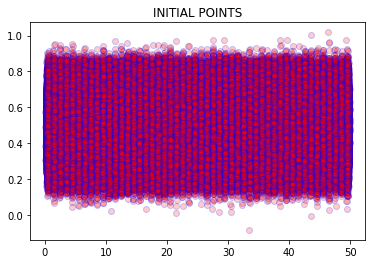

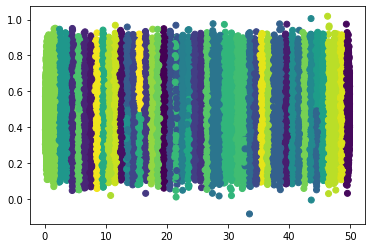

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
random.seed(0)

K = 5
N = 1000
points = initializePoints(N, K)
# points = np.array([[0.5, 0.5], [1.5, 0.5], [2.5, 0.5], [3.5, 0.5], [4.5, 0.5]])

plt.scatter(*zip(*points), color='red', alpha = 0.2, edgecolor='blue')
plt.title("INITIAL POINTS")
plt.show()

clusters, centroids = runKMeans(points,K,N,True)

plt.scatter(points[:, 0], points[:, 1], c=clusters)
plt.show()
#print ("The score of best Kmeans clustering is:", clusterQuality(points, clusters, centroids))